# Gesture Recognition Case Study

#### CNN + RNN Approach

In [35]:
import numpy as np
import datetime
import cv2
import os
from scipy.misc import imread, imresize
import random as rn
from keras import backend as K
import tensorflow as tf
import glob
from skimage import io
import matplotlib.pyplot as plt
from skimage.transform import resize

In [36]:
# images coming from 2 sources with different resolution. Unify them to 100*100
img_r = 100
img_c = 100
frames = 10  #using every 3rd frame (so overall 30 becomes 10)
channel_count = 3
class_count = 5


np.random.seed(101)
rn.seed(101)
tf.set_random_seed(101)



#loading data
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())

#Data expected according to below path structure
train_path = './Project_data/train'
val_path = './Project_data/val'


batch_size = 16

#### Utility Functions

In [37]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

In [38]:
def print_image_with_metadata(image):
    print("image shape is: {}".format(image.shape))
    print("image min: "+str(image.min())+"  image max: "+str(image.max()))
    plt.imshow(image);
    

In [39]:
from skimage import transform as trf
def scale_image(image, scale_value):
    scale_matrix = trf.AffineTransform(scale=(scale_value,scale_value))
    scaled_image = trf.warp(image, scale_matrix)
    return scaled_image

In [40]:
def normalize_image(image):
    image = (image - np.min(image))/(np.max(image) - np.min(image))
    return image

In [41]:
def crop_and_resize_image(img):
    if img.shape[0] != img.shape[1]:
        img=img[0:120,10:150]
    resized_image = resize(img, (img_r,img_c))
    return resized_image

#### Sample One
Fetching a random 360 by 360 frame from a training video as sample

image shape is: (360, 360, 3)
image min: 0  image max: 255


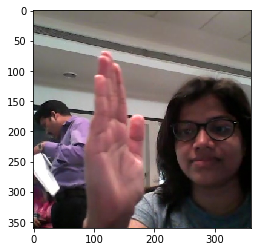

In [42]:
# Sample Video One: WIN_20180907_15_35_09_Pro_Right 

video_path_one = os.path.join(train_path,"WIN_20180907_15_35_09_Pro_Right Swipe_new" , '*')
video_path_contents_one = glob.glob(video_path_one)

# access 10th frame(image) from the video
sample_image_one = io.imread(video_path_contents_one[10])
print_image_with_metadata(sample_image_one)

#### Sample Two
Fetching a random 160 by 120 frame from a training video as sample

image shape is: (120, 160, 3)
image min: 0  image max: 255


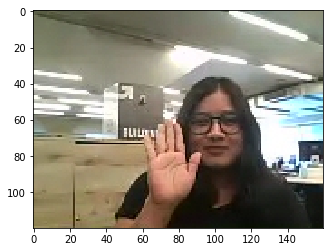

In [43]:
# Sample Video: WIN_20180925_17_31_48_Pro_Stop_new

video_path_two = os.path.join(train_path,"WIN_20180925_17_31_48_Pro_Stop_new" , '*')
video_path_contents_two = glob.glob(video_path_two)

# access some element (a file) from the list
sample_image_two = io.imread(video_path_contents_two[10])
print_image_with_metadata(sample_image_two)

### Bringing down both the images to the same scale by transforming them

Cropping and resizing

image shape is: (100, 100, 3)
image min: 0.0  image max: 1.0


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


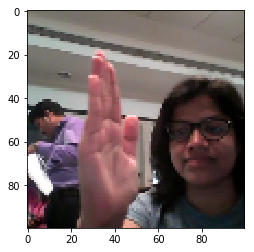

In [44]:
# Let's try and bring both the images to an aribtrary scale of (img_rows,img_cols,img_channels)
sample_image_one_cropped = crop_and_resize_image(sample_image_one)
print_image_with_metadata(sample_image_one_cropped)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


image shape is: (100, 100, 3)
image min: 0.0  image max: 1.0


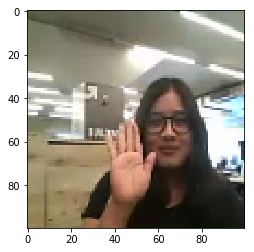

In [45]:
# sample_image_two with size 160 by 120 needs to be cropped before resizing. Custom cropping dimensions(found by trial and error)
# are defined in function crop_and_resize_image

sample_image_two_cropped = crop_and_resize_image(sample_image_two)
print_image_with_metadata(sample_image_two_cropped)

## Checking class imbalance if any

In [46]:
category_list = [int(item.split(";")[-1].strip('\n')) for item in train_doc]
for i in range(class_count):
    print("category {} count is: {}".format(i,category_list.count(i)))
    

category 0 count is: 136
category 1 count is: 137
category 2 count is: 130
category 3 count is: 137
category 4 count is: 123


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [47]:
def get_batch_data(source_path, current_batch_size, full_batch_size, t, batch, img_idx):
          
          # current_batch_size != full_batch_size, in case of partial batches
          # current_batch_size = full_batch_size, in case of full batches
            
          # initialize batch_data
            x, y, z, channels = len(img_idx), img_r, img_c, channel_count  
            batch_data = np.zeros((current_batch_size,x,y,z,channels)) # batch_data has a place holder for all sequences(videos) in a batch 
            
            # initilaize batch_labels
            batch_labels = np.zeros((current_batch_size,5)) # batch_labels is the one hot representation of the output
            
            # iterate over folders in a batch
            for folder in range(current_batch_size):  # Each folder represents one video
                
                # read all the images in the folder
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*full_batch_size)].split(';')[0])
                
                # iterate over the frames/images of a folder to read them in
                for idx,item in enumerate(img_idx): 
                    image = io.imread(source_path+'/'+ t[folder + (batch*full_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    resized_image = crop_and_resize_image(image)
                    
                    # normalize images(per channel)
                    batch_data[folder,idx,:,:,0] = normalize_image(resized_image[:, : , 0])
                    batch_data[folder,idx,:,:,1] = normalize_image(resized_image[:, : , 1])
                    batch_data[folder,idx,:,:,2] = normalize_image(resized_image[:, : , 2])
                                       
                batch_labels[folder, int(t[folder + (batch*full_batch_size)].strip().split(';')[2])] = 1
            #print("batch_data_updated............{}".format(batch_data))
            #print("batch_labels_updated..............{}".format(batch))
            return batch_data, batch_labels

In [48]:
def generator(source_path, folder_list, batch_size, ablation=False, validation = False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)

    #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30,3)]
    
    while True:
        t = np.random.permutation(folder_list)
        num_folders = len(t)
        
        # number of full batches
        num_batches = int(np.floor(num_folders/batch_size))
        
        # derive partial batch size(if any)
        partial_batch_size = 0
        num_folders_in_full_batch = batch_size*num_batches
        
        if (num_folders != num_folders_in_full_batch):
            partial_batch_size = num_folders - num_folders_in_full_batch
        
        # generate data from full batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data, batch_labels = get_batch_data(source_path, batch_size, batch_size, t, batch, img_idx)
            yield batch_data, batch_labels
                            
        # generate data from partial batches
        if (partial_batch_size > 0):
            partial_batch_number =  batch + 1
            partial_batch_data, partial_batch_labels =  get_batch_data(source_path, partial_batch_size, batch_size, t, partial_batch_number, img_idx)
            yield partial_batch_data, partial_batch_labels

In [49]:
my_gen = generator(train_path, train_doc, batch_size)
next(my_gen)

Source path =  ./Project_data/train ; batch size = 16


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(array([[[[[7.00513314e-01, 7.24734762e-01, 6.71087428e-01],
           [7.06448508e-01, 7.30892449e-01, 6.76929149e-01],
           [7.02157523e-01, 7.15206990e-01, 6.82178804e-01],
           ...,
           [5.88867501e-01, 6.60079051e-01, 6.49615157e-01],
           [5.92677254e-01, 6.59871021e-01, 6.33629366e-01],
           [5.95925569e-01, 6.58664448e-01, 6.23406355e-01]],
 
          [[7.29828361e-01, 7.52236322e-01, 7.21255181e-01],
           [7.25858197e-01, 7.48117329e-01, 7.17347543e-01],
           [7.27021174e-01, 7.41002704e-01, 7.06650878e-01],
           ...,
           [5.87263394e-01, 6.58414812e-01, 6.48036313e-01],
           [5.89469041e-01, 6.56542542e-01, 6.30471679e-01],
           [5.97890600e-01, 6.60703141e-01, 6.25340438e-01]],
 
          [[7.25818094e-01, 7.56396921e-01, 7.25202289e-01],
           [7.29427334e-01, 7.60141460e-01, 7.28754687e-01],
           [7.37848893e-01, 7.60557520e-01, 7.21255181e-01],
           ...,
           [5.45356112e-01, 6.0

In [50]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =25
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [51]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.layers.recurrent import LSTM, GRU

# Input
input_shape=(frames,img_r,img_c,channel_count)
featuremap_list = [8,16,32,64]
dense_list = [32,16]

model = Sequential()




model.add(TimeDistributed(Conv2D(featuremap_list[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))

model.add(TimeDistributed(Conv2D(featuremap_list[1], (3,3),padding='same', activation='relu')))

model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(featuremap_list[2], (3,3),padding='same', activation='relu')))

model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(featuremap_list[3], (2,2),padding='same', activation='relu')))

model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))


model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(dense_list[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(dense_list[1], activation='relu'))
model.add(Dropout(0.25))


model.add(GRU(64, return_sequences=False))

model.add(Dense(class_count, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [52]:
from keras.optimizers import Adam
from keras.optimizers import sgd

optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 10, 50, 50, 8)     224       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 10, 50, 50, 16)    1168      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 10, 25, 25, 16)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 10, 25, 25, 32)    4640      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 10, 12, 12, 32)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 10, 12, 12, 64)    8256      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 10, 6, 6, 64)      0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [53]:
train_generator = generator(train_path, train_doc, batch_size)

val_generator = generator(train_path, train_doc, batch_size)

In [54]:
model_name = 'CNN_RNN_Models/Experiments' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [55]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [56]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 16
Source path =  ./Project_data/train ; batch size =Epoch 1/25
 16


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


42/42 [==============================] - 95s 2s/step - loss: 1.4373 - categorical_accuracy: 0.3684 - val_loss: 1.6595 - val_categorical_accuracy: 0.3393

Epoch 00001: saving model to CNN_RNN_Models/Experiments_2019-06-2414_32_41.132451/model-00001-1.43557-0.36953-1.65946-0.33929.h5
Epoch 2/25
42/42 [==============================] - 35s 835ms/step - loss: 1.1649 - categorical_accuracy: 0.5232 - val_loss: 1.5184 - val_categorical_accuracy: 0.4107

Epoch 00002: saving model to CNN_RNN_Models/Experiments_2019-06-2414_32_41.132451/model-00002-1.15960-0.52640-1.51841-0.41071.h5
Epoch 3/25
42/42 [==============================] - 36s 864ms/step - loss: 1.0277 - categorical_accuracy: 0.6022 - val_loss: 1.3142 - val_categorical_accuracy: 0.4554

Epoch 00003: saving model to CNN_RNN_Models/Experiments_2019-06-2414_32_41.132451/model-00003-1.03269-0.59879-1.31424-0.45536.h5
Epoch 4/25
42/42 [==============================] - 36s 861ms/step - loss: 0.8462 - categorical_accuracy: 0.6572 - val_loss